In [208]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from itertools import product
from tqdm import tqdm_notebook

In [209]:
# import dataset as pandas.DataFrame
data = pd.read_csv('a.tsv', sep='\t', header=0, names=['Person', 'Date', 'Input', 'Result'])

In [211]:
# აბრუნებს data[row[col]-ის მნიშვნელობას. jsn=True იმ შემთხვევაში თუ სვეტის ელემენტი json ფორმატში არის შენახული
# და ჭირდება დესერილიზაცია

def get_value(data, row, col, jsn):
    if jsn:
        return json.loads(data.iloc[row, col])
    else:
        return data.iloc[row, col]
    
def get_size(data, person):
    return data.loc[data.Person == person, ['Person']].shape[0]

In [212]:
persons = data['Person'].unique()
dt = data.copy()
mp = {}
for person in persons:
    mp[person] = get_size(data, person)
rs = []
for i in data.index:
    rs.append(mp[get_value(data, i, 0, False)])
dt['cnt'] = rs
dt = dt.loc[dt.cnt >= 50, :]
data = dt
data.head()

,Person,Date,Input,Result,cnt
0,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",173
1,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",173
2,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",173
3,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",173
4,1,2014-09-19,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2158}...",173


In [214]:
def calories_goal_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['goal'][i]['name'] == 'Calories':
            return result['goal'][i]['value']
    return -1

In [215]:
def calories_total_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Calories':
            return result['total'][i]['value']
    return -1

In [216]:
def get_difference(data, row):
    result = get_value(data, row, 3, True)
    total_calories = 0
    goal_calories = 0
    total_sugar = 0
    goal_sugar = 0
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Sugar':
            total_sugar = result['total'][i]['value']
        if result['total'][i]['name'] == 'Calories':
            total_calories = result['total'][i]['value']
        if result['goal'][i]['name'] == 'Calories':
            goal_calories = result['goal'][i]['value']
        if result['goal'][i]['name'] == 'Sugar':
            goal_sugar = result['goal'][i]['value']
    return abs(goal_calories - total_calories), abs(goal_sugar - total_sugar)

In [217]:
def get_date_index(dates, date):
    for i in range(len(dates)):
        if dates[i] == date:
            return i
    return -1

In [218]:
def dates_contains_date(dates, date):
    for cur_date in dates:
        if cur_date == date:
            return True
    return False

In [231]:
remaining_persons = data['Person'].to_numpy()
person_id = remaining_persons[276];
person_dt = data.loc[data.Person == person_id, :].copy()
person_dates = person_dt['Date'].to_numpy()
dates = data['Date'].unique()

In [232]:
new_dates = []
for date in dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_dates.append(x)
dates = new_dates
dates.sort()
new_person_dates = []
for date in person_dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_person_dates.append(x)
person_dates = new_person_dates
person_dates.sort()

In [233]:
# print(dates)
# print(person_dates)
beta = 0.7
lst = []
lst2 = []
for i in person_dt.index:
    lst.append(get_difference(data, i)[0])
    lst2.append(get_difference(data, i)[1])
mx = max(lst)
mx2 = max(lst2)
if mx == 0:
    mx = 1
if mx2 == 0:
    mx2 = 1
for i in range(len(lst)):
    lst[i] /= mx 
    lst[i] = lst[i] * 0.7 * 100
    lst2[i] /= mx2 
    lst2[i] = lst2[i] * 0.3 * 100
    
results = []
lsts_index = 0
frm = get_date_index(dates, person_dates[0])
to = get_date_index(dates, person_dates[len(person_dates) - 1])
missed_days = 0
for i in range(frm, to+1):
    date = dates[i]
    if not dates_contains_date(person_dates, date):
        missed_days += 1
        results.append(results[len(results) - 1] * beta)
    else:
        if len(results) == 0:
            results.append((1 - beta) * (100 - lst[lsts_index] - lst2[lsts_index]))
        else:
            results.append(results[len(results) - 1] * beta + (1 - beta) * (100 - lst[lsts_index] - lst2[lsts_index]))
        lsts_index += 1

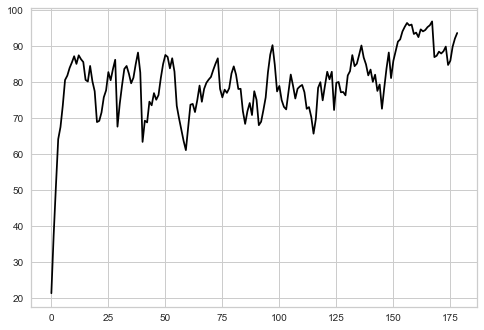

In [234]:
# lst = []
# lst2 = []
# for i in person_dt.index:
#     lst.append(get_difference(data, i)[0])
#     lst2.append(get_difference(data, i)[1])
# mx = max(lst)
# mx2 = max(lst2)
# lst3 = []
# alpha = 0.7
# for i in range(len(lst)):
#     lst[i] /= mx 
#     lst[i] = lst[i] * 0.7 * 100
#     lst2[i] /= mx2 
#     lst2[i] = lst2[i] * 0.3 * 100
#     if i > 0:
#         lst3.append(alpha * lst3[i-1] + (1 - alpha) * (100 - lst[i] - lst2[i]))
#     else: 
#         lst3.append( alpha * (100 - lst[i] - lst2[i]))
plt.plot(results, color='black')
plt.show()